# Lasso(L1 Regularization) Regression

## Generate Data

In [20]:
import pandas as pd 
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns

from matplotlib import animation
from IPython import display

from utility import regression_animation, add_axis_for_bias, predict

In [11]:
X1,y1 = make_regression(n_samples=300, n_features=1, noise=20,random_state=0)

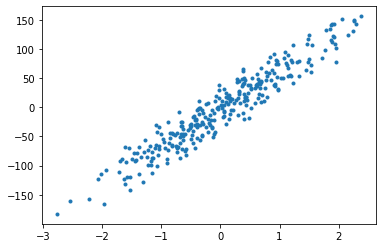

In [31]:
plt.plot(X1,y1,'.')

- Shape of X
            
           X = (m,n)
           where 
               m = number of samples 
               n = number of features 
     
- setup $X_0$ (column 0 as 1) for bias in linear regression $( θ_0 \times X_0 + θ_1 \times X_1  = θ_0 + θ_1 \times X_1 )$

In [32]:
def add_axis_for_bias(X_i):
    
    X_i = X_i.copy()
    if len(X_i.shape) == 1:
        X_i = X_i.reshape(-1,1)

    if False in (X_i[...,0] == 1):        
        return np.hstack(tup=(np.ones(shape=(X_i.shape[0],1)) , X_i))
    else:
        return X_i

In [33]:
X = add_axis_for_bias(X1)
y = y1.reshape(-1,1)

print(X.shape, y.shape)

(300, 2) (300, 1)


In [35]:
n = X.shape[1]
m = y.shape[0]
print("number of columns (features) :",n)
print("number of samples (rows) :",m)

number of columns (features) : 2
number of samples (rows) : 300


## Loss Function 

\begin{align}
    J(\theta) &= \frac{1}{2m}[{\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}{\theta_j}}] \\
    \frac{\partial{J(\theta)}}{\partial{\theta}} &= \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x^{(i)}} + \frac{\lambda}{2m}
\end{align}

In [36]:
def derivative(X, y, y_pred):
    return np.mean( ( y_pred - y ) * X, axis = 0 )

def calculate_cost(y_pred,y):
    return np.mean(np.square(y_pred - y)) / 2 

## Algorithm

\begin{align}
    \text{repeat until convergence \{}\\
    \theta_0 &:= \theta_0 - \alpha \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.x_0^{(i)}\\
    \theta_j &:= \theta_j - \alpha [ \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{2m} ]\\
    \text{\} j = 1,2,3,...,n}
\end{align} 

## Lasso with BGD



In [37]:


def lasso_regression_bgd(X, y, verbose=True, theta_precision = 0.001, alpha = 0.01,
                         iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    n = X.shape[1]
    m = y.shape[0]

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision
#     if verbose: print("random initial θ value :",theta)

    for iteration in range(iterations):
        # calculate y_pred 
        y_pred = predict(theta,X)

        # new θ to replace old θ
        new_theta = None
        
        
        # simultaneous operation     
        gradient = derivative(X,y,y_pred)
        new_theta_0 = theta[:,[0]] - (alpha * gradient[0])
        new_theta_rest = theta[:,range(1,n)] - (alpha * (gradient[1:] + (penalty/(2 * m))))

        new_theta = np.hstack((new_theta_0,new_theta_rest))

        # simultaneous operation 
        gradient = derivative(X,y,y_pred)
        new_theta = theta - (alpha *  gradient)

        if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
            print("breaking. found inf or nan.")
            break
        # override with new θ 
        theta = new_theta

        # calculate cost to put in history
        cost = calculate_cost(y_pred = predict(theta,X), y = y)
        cost_history.append(cost)

        # calcualted theta in history
        theta_history.append(theta[0])
        
    return theta, np.array(theta_history), np.array(cost_history)

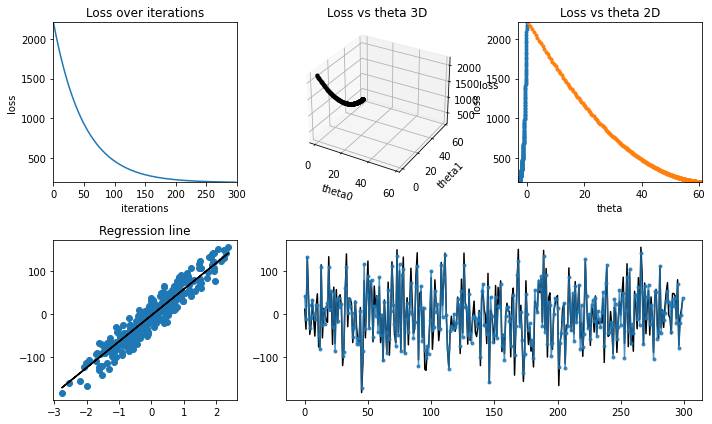

In [43]:
X = X1
y = y1.reshape(-1,1)
iterations = 300
learning_rate = 0.01
penalty = 1.0
theta1, theta_history, cost_history = lasso_regression_bgd(X, y, verbose=True, theta_precision = 0.001, 
                                                           alpha = learning_rate ,iterations = iterations, 
                                                           penalty=penalty)

y_pred2 = predict(theta1, X)
anim = regression_animation(X, y, cost_history, theta_history, iterations, interval=30)
display.HTML(anim.to_html5_video())

## Lasso with SGD

In [44]:
        
def lasso_regression_sgd(X, y, verbose=True, theta_precision = 0.001, batch_size=30, alpha = 0.01,
                         iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    n = X.shape[1]
    m = y.shape[0]

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision
#     if verbose: print("random initial θ value :",theta)
    
    for iteration in range(iterations):

        # creating indices for batches
        indices = np.random.randint(0,m,size=batch_size)

        # creating batch for this iteration
        X_batch = np.take(X,indices,axis=0)
        y_batch = np.take(y,indices,axis=0)

        # calculate y_pred 
        y_pred = predict(theta,X_batch)
        # new θ to replace old θ
        new_theta = None

        # simultaneous operation 
        gradient = derivative(X_batch,y_batch,y_pred)
        new_theta_0 = theta[:,[0]] - (alpha * gradient[0])
        new_theta_rest = theta[:,range(1,n)] - (alpha * (gradient[1:] + (penalty/(2 * m))))

        new_theta = np.hstack((new_theta_0,new_theta_rest)) 
        if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
            print("breaking. found inf or nan.")
            break
        # override with new θ 
        theta = new_theta

        # calculate cost to put in history
        cost = calculate_cost(y_pred = predict(theta,X_batch), y = y_batch)
        cost_history.append(cost)

        # calcualted theta in history
        theta_history.append(theta[0])
    return theta, np.array(theta_history), np.array(cost_history)

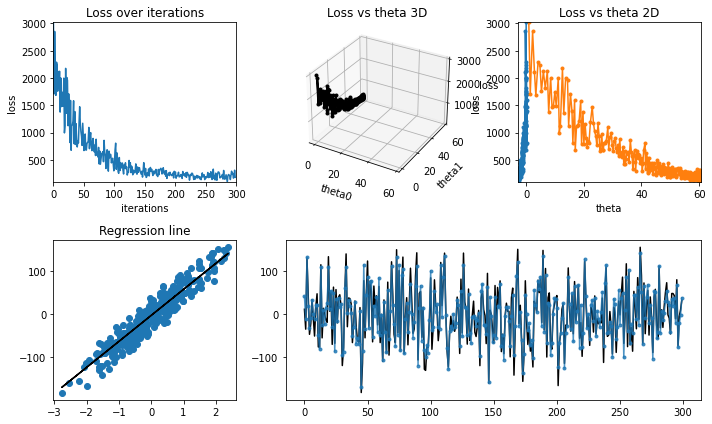

In [45]:
X = X1
y = y1.reshape(-1,1)
iterations = 300
learning_rate = 0.01
penalty = 1.0
theta1, theta_history, cost_history = lasso_regression_sgd(X, y, verbose=True, theta_precision = 0.001, 
                                                           alpha = learning_rate ,iterations = iterations, 
                                                           penalty=penalty)

y_pred2 = predict(theta1,X)
anim = regression_animation(X, y, cost_history,theta_history, iterations, interval=30)
display.HTML(anim.to_html5_video())